In [1]:
import numpy as np
#from qutip import *
from math import sqrt
from scipy import *
import scipy.linalg

from numpy.linalg import eig
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout,LSTM
import sys
import scipy.linalg
%matplotlib inline

# Training the LSTM network
Network is trained on random Guassian fields for Jt in[0,7], later we evaluate the network on unseen random Guassian fields, quench and periodic fields for Jt in [0,20]

In [9]:
Result_train1=pd.read_csv("Result_train_tau=20,M=7,num_train=50000,seed_train=123.dat", header=None)

Data_test1=pd.read_csv("Data_test_tau=20,M=7,num_test=1000,seed_test=1451.dat", header=None)
Result_test1=pd.read_csv("Result_test_tau=20,M=7,num_test=1000,seed_test=1451.dat", header=None)
Data_train1=pd.read_csv("Data_train_tau=20,M=7,num_train=50000,seed_train=123.dat", header=None)

In [ ]:
def prepare_data(Result_train, Data_train, Result_test, Data_test, generalization_steps, extrapolation_steps):
    """
    Prepare the data for training and testing by reshaping and combining input features and output labels.

    Parameters:
    - Result_train (list or array): all expectation values for all  time steps for training set. 
    - Data_train (list or array): Random Guassian magnetic fields for all  time steps .
    - Result_test (list or array): all expectation values for all  time steps for test set.
    - Data_test (list or array): Random Guassian magnetic fields for all time steps.
    - generalization_steps (int): Number of generalization steps.
    - extrapolation_steps (int): Number of extrapolation steps.

    Returns:
    - x_train (array): Input features for training data.
    - y_train (array): Output labels for training data.
    - x_test (array): Input features for test data.
    - y_test (array): Output labels for test data.

    Notes:
    - Assumes that the lengths of `Result_train`, `Data_train`, `Result_test`, and `Data_test` are consistent.
    - The output arrays (`x_train`, `y_train`, `x_test`, `y_test`) are formatted based on the specified generalization
      and extrapolation steps.
    """


   
    
    Result_train = np.array(Result_train).reshape(len(Data_train), len(taulist_extrapolation), 9*(L-1)+3)
    Result_train = Result_train[:, :generalization_steps, :].reshape(len(Result_train), generalization_steps*(9*(L-1)+3))
    Result_test = np.array(Result_test).reshape(len(Result_test), extrapolation_steps*(9*(L-1)+3))
    Data_train = np.array(Data_train)[:, :generalization_steps]
    Data_test = np.array(Data_test)[:, :extrapolation_steps]
    x_train = np.zeros((len(Result_train), generalization_steps, 5))
    x_test = np.zeros((len(Result_test), extrapolation_steps, 5))

    x_train[:, :, :1] = Data_train.reshape(Data_train.shape[0], generalization_steps, 1)
    x_test[:, :, :1] = Data_test.reshape(Data_test.shape[0], extrapolation_steps, 1)

    x_train[:, 0, 1:4] = Result_train[:, :3]
    x_test[:, 0, 1:4] = Result_test[:, :3]
    x_train[:, :, 4:5] = (np.repeat(taulist_generalization[:, np.newaxis], len(x_train), axis=1).T).reshape(
        len(x_train), generalization_steps, 1)
    x_test[:, :, 4:5] = (np.repeat(taulist_extrapolation[:, np.newaxis], len(x_test), axis=1).T).reshape(
        len(x_test), extrapolation_steps, 1)
    



    y_train = Result_train.reshape(len(Result_train), len(taulist_generalization), 9*(L-1)+3)
    y_test = Result_test.reshape(len(Result_test), len(taulist_extrapolation), 9*(L-1)+3)



    return x_train, y_train, x_test, y_test


def build_lstm_model(input_shape):
    """
    the input of the network is (Magnetic_field,<sz,t=0>,<sy,t=0>,<sx,t=0>,time) 
    the output of the network is expectation value of the ovservables 9(L-1)+3
    """
    net = Sequential()
    net.add(LSTM(700, batch_input_shape=input_shape, return_sequences=True))
    net.add(LSTM(700, return_sequences=True))
    net.add(LSTM(700, return_sequences=True))
    net.add(LSTM(700, return_sequences=True))
    net.add(Dense(9*(L-1)+3))
    net.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
    return net


def plot_training_history(history):
    plt.plot(history.history['val_mean_squared_error'], linewidth=3)
    plt.plot(history.history['mean_squared_error'], linewidth=3)
    legend = plt.legend(('MSE_validation', 'MSE_train'))
    plt.xlabel('number of epochs', fontsize=21)
    plt.ylabel('MSE', fontname="cal", fontweight="bold", fontsize=25)
    plt.title('M=7, LSTM', fontsize=25)
    plt.show()
    plt.yscale('log')


tau_max_generalization = 7
tau_max_extrapolation = 20
generalization_steps = 35
extrapolation_steps = 100
M = 7
L = int((M-1)/2)+1

# Data Preparation
x_train, y_train, x_test, y_test = prepare_data(Result_train1, Data_train1, Result_test1, Data_test1, generalization_steps, extrapolation_steps)

# Model Creation
input_shape = (None, None, 5)  # Shape of input data (Magnetic_field, <sz,t=0>, <sy,t=0>, <sx,t=0>, time)
net = build_lstm_model(input_shape)

# Model Training
history = net.fit(x=x_train, y=y_train, batch_size=1000, epochs=50, validation_split=0.1)

# Model Evaluation
error = net.evaluate(x=x_test, y=y_test)

# Plotting Training History

findfont: Font family 'cal' not found.
findfont: Font family 'cal' not found.


findfont: Font family 'cal' not found.
findfont: Font family 'cal' not found.
findfont: Font family 'cal' not found.


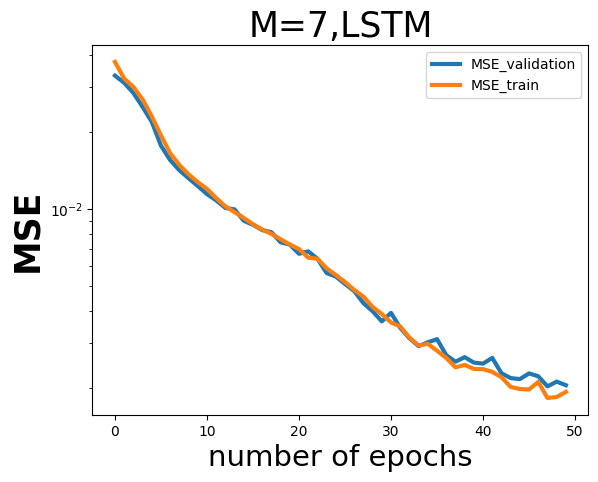

In [7]:
plt.plot(history.history['val_mean_squared_error'], linewidth=3)
plt.plot(history.history['mean_squared_error'], linewidth=3)
legend=plt.legend(('MSE_validation','MSE_train'))
plt.xlabel('number of epochs',fontsize=21)
plt.ylabel('MSE',fontname="cal",fontweight="bold",fontsize=25)
plt.title('M=7,LSTM',fontsize=25)
plt.yscale('log')
plt.show()


In [17]:
net.save_weights("weights_lstm.h5")

### Evaluating the network on unseen random Guassian fields
 (Jt $\in$[0,7] is generalization window and Jt $\in$ [7,20] is the extrapolation window)
 below figures show different predicted and real expectations for different random trajectories of Guassian magnetic field
 

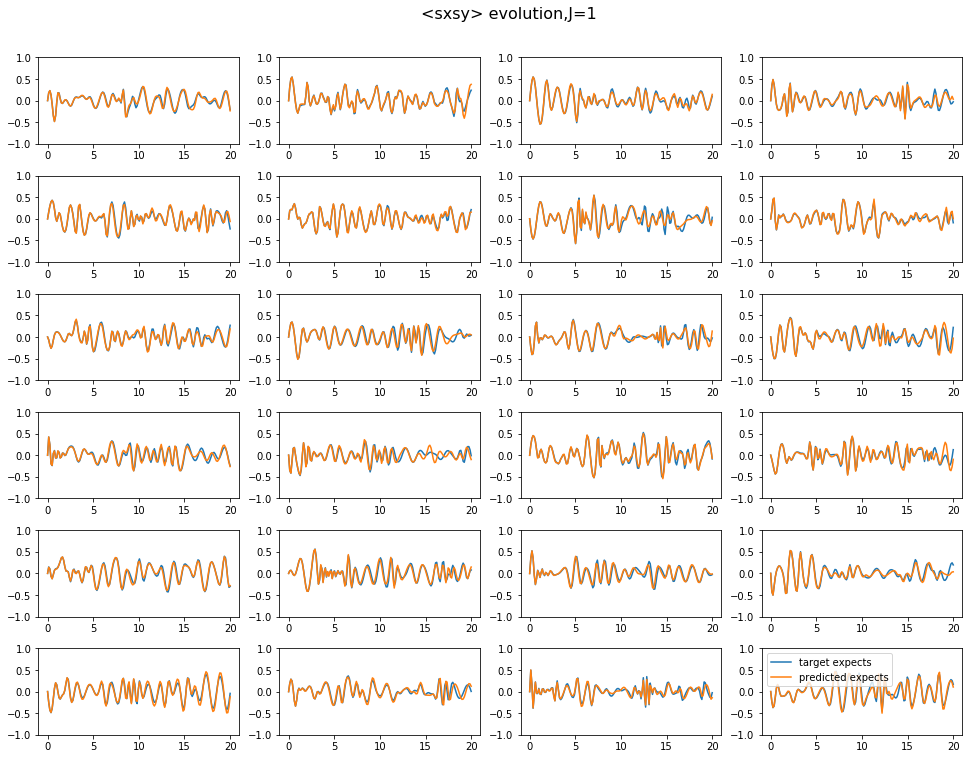

In [7]:
#up to 7
l=3+7*(L-1)
fig, axes = plt.subplots(6, 4, figsize=(14,10))
fig.tight_layout()
fig.suptitle('<sxsy> evolution,J=1',size=16, y=1.05)
for j in range(4):
    for k in range(6*j,6*(j+1)):
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_test),1,2)[k][l])
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_predict),1,2)[k][l])
        axes[k-6*j,j].set_ylim(-1,1)
        
legend=plt.legend(('target expects','predicted expects'))
#legend.draggable()
plt.subplots_adjust(right=0.95)

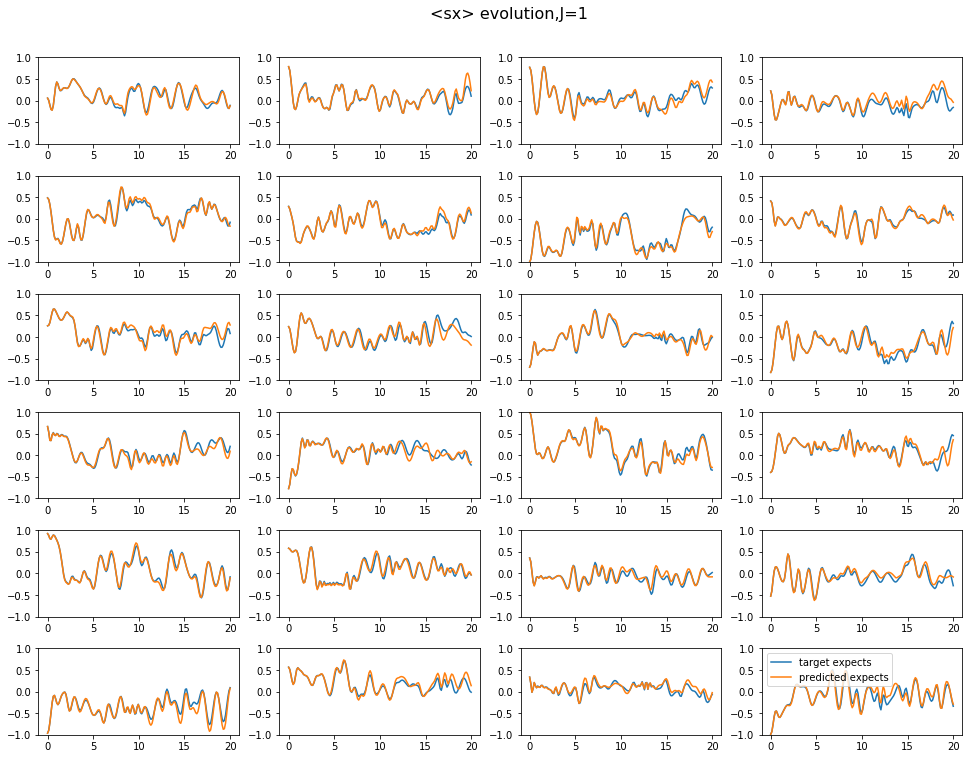

In [8]:

l=2
fig, axes = plt.subplots(6, 4, figsize=(14,10))
fig.tight_layout()
fig.suptitle('<sx> evolution,J=1',size=16, y=1.05)
for j in range(4):
    for k in range(6*j,6*(j+1)):
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_test),1,2)[k][l])
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_predict),1,2)[k][l])
        axes[k-6*j,j].set_ylim(-1,1)
        
legend=plt.legend(('target expects','predicted expects'))
#legend.draggable()
plt.subplots_adjust(right=0.95)

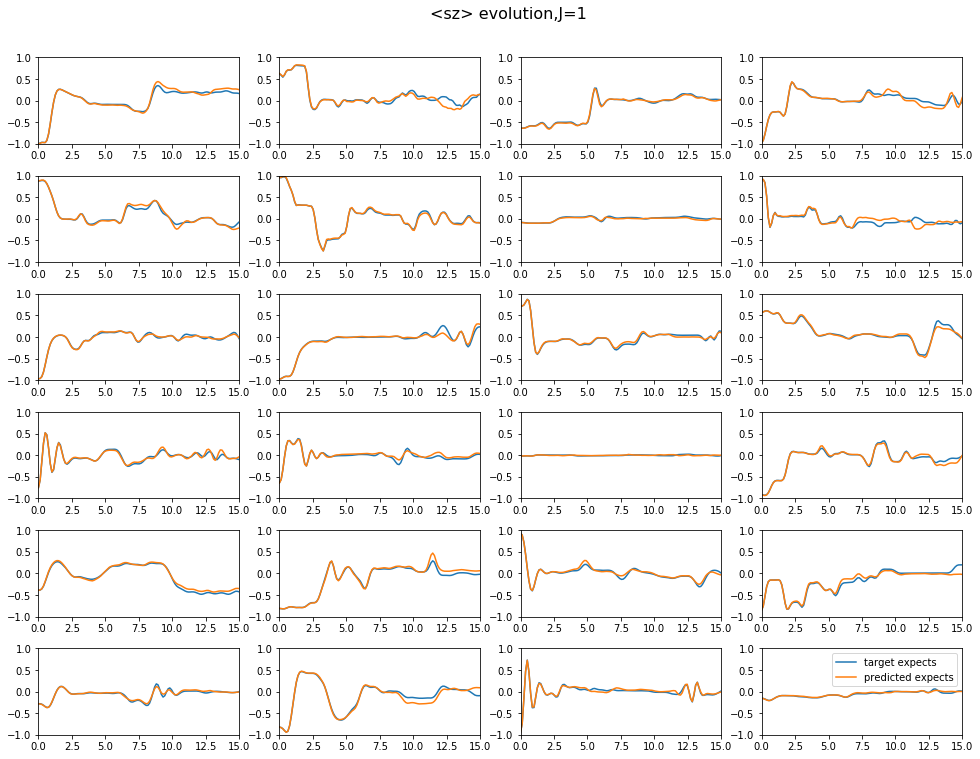

In [11]:
#up to 7
l=0
fig, axes = plt.subplots(6, 4, figsize=(14,10))
fig.tight_layout()
fig.suptitle('<sz> evolution,J=1',size=16, y=1.05)
for j in range(4):
    for k in range(6*j,6*(j+1)):
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_test),1,2)[k][l])
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_predict),1,2)[k][l])
        axes[k-6*j,j].set_ylim(-1,1)
        axes[k-6*j,j].set_xlim(0,15)
        
legend=plt.legend(('target expects','predicted expects'))
#legend.draggable()
plt.subplots_adjust(right=0.95)

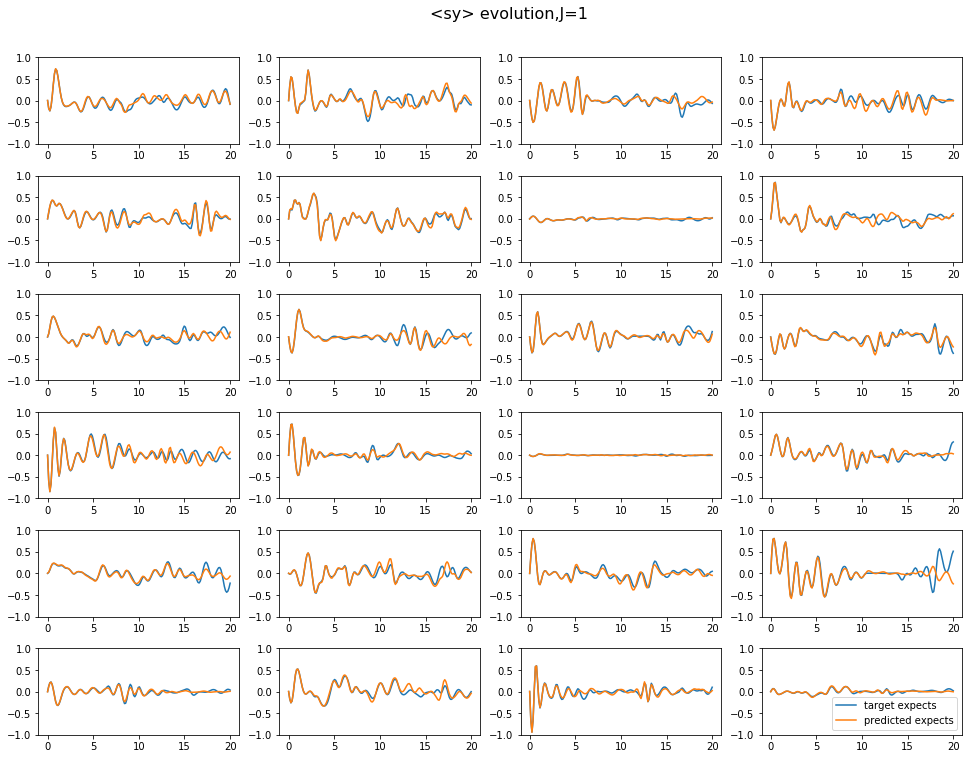

In [10]:
#up to 7
l=1
fig, axes = plt.subplots(6, 4, figsize=(14,10))
fig.tight_layout()
fig.suptitle('<sy> evolution,J=1',size=16, y=1.05)
for j in range(4):
    for k in range(6*j,6*(j+1)):
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_test),1,2)[k][l])
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_predict),1,2)[k][l])
        axes[k-6*j,j].set_ylim(-1,1)
        
legend=plt.legend(('target expects','predicted expects'))
#legend.draggable()
plt.subplots_adjust(right=0.95)

# Evaluating network on quench trajectories

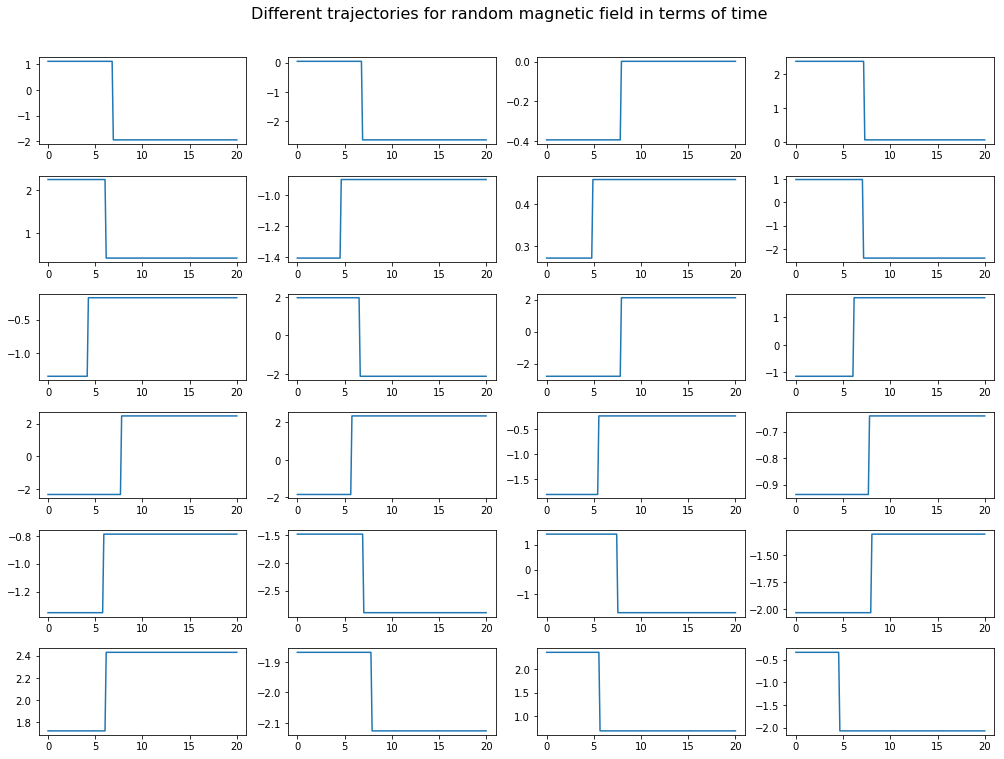

In [17]:

fig, axes = plt.subplots(6, 4, figsize=(14,10))
fig.tight_layout()
fig.suptitle('Different trajectories for random magnetic field in terms of time',size=16, y=1.05)
 

for j in range(4):
    for k in range(6*j,6*(j+1)):
        axes[k-6*j,j].plot(taulist,np.array(Data_test_step)[k])

<font size="8">Extrapolating to longer time</font>

In [5]:
Data_test_step=pd.read_csv("Data_test_step_tau=20,M=7,num_test=1000,seed_test=1451.dat", header=None)
Result_test_step=pd.read_csv("Result_test_step_tau=20,M=7,num_test=1000,seed_test=1451.dat", header=None)

1000/1000 [==============================] - 7s 7ms/sample - loss: 0.0045 - mean_squared_error: 0.0045


array([0.0028748 , 0.00415331, 0.004874  , 0.00567773, 0.00621604,
       0.00648403, 0.00705217, 0.00752984, 0.00788759, 0.00856486,
       0.00934872, 0.00982082, 0.01034324, 0.01113387, 0.01189308,
       0.01241535, 0.01307423, 0.01347664, 0.0138316 , 0.01446706,
       0.01539728, 0.01598177, 0.01687467, 0.01810084, 0.01924621,
       0.02060605, 0.02273599, 0.02440153, 0.02592851, 0.02695288,
       0.02794247, 0.02865472, 0.02898874, 0.0305799 , 0.0307359 ,
       0.0303651 , 0.0309419 , 0.03083372, 0.03117407, 0.03225466,
       0.03380782, 0.03549147, 0.03643498, 0.03701623, 0.03706508,
       0.03781001, 0.03974935, 0.04045906, 0.04119018, 0.04236749,
       0.04379896, 0.04460353, 0.04534503, 0.0462603 , 0.04711913,
       0.04832951, 0.0489446 , 0.04929623, 0.05029029, 0.0521126 ,
       0.05325103, 0.05467997, 0.0574341 , 0.05851693, 0.05896645,
       0.05895443, 0.05840135, 0.05787657, 0.05781014, 0.05778525,
       0.05806311, 0.05872289, 0.05927063, 0.05887921, 0.05877

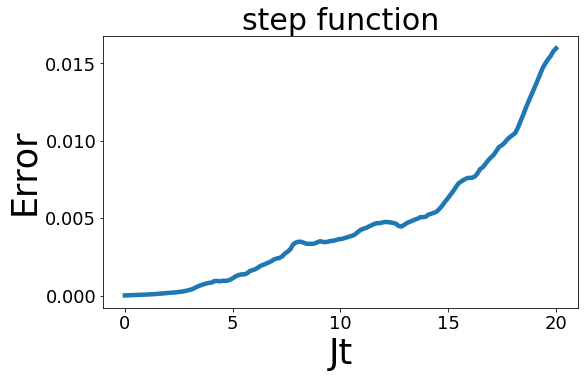

In [13]:





taulist=np.linspace(0,tau_max_extrapolation,extrapolation_steps)
Data_test_step=np.array(Data_test_step)
Result_test_step=np.array(Result_test_step).reshape(len(Result_test_step),len(taulist),9*(L-1)+3)
Result_test_step=Result_test_step[:,:extrapolation_steps,:].reshape(len(Result_test_step),extrapolation_steps*(9*(L-1)+3))
x_test_step=np.zeros((len(Result_test_step),extrapolation_steps,5))
x_test_step[:,:,:1]=Data_test_step.reshape(Data_test_step.shape[0],extrapolation_steps,1)
x_test_step[:,0,1:4]=Result_test_step[:,:3]
x_test_step[:,:,4:5]=(np.repeat(taulist[:,np.newaxis],len(x_test_step),axis=1).T).reshape(len(x_test_step),extrapolation_steps,1)
y_test_step=Result_test_step.reshape(len(Result_test_step),len(taulist),9*(L-1)+3)
error=net.evaluate(x=x_test_step,y=y_test_step)
y_target_step=y_test_step
y_predict_step = net.predict(x_test_step)
yy_predict_step=y_predict_step

num_test=1000
data=(1./(num_test*(9*(L-1)+3)) )*sum((np.swapaxes(np.array(y_target_step),1,2)[:,:,:]-np.swapaxes(np.array(yy_predict_step),1,2)[:,:,:])**2,axis=(0,1))
data2=(1./(num_test*(9*(L-1)+3)) )*sum((np.swapaxes(np.array(y_target_step),1,2)[:,:,:]-np.swapaxes(np.array(yy_predict_step),1,2)[:,:,:])**4,axis=(0,1))

plt.figure(figsize=(8.5,5))

plt.plot(taulist,data,linewidth=4.5)
plt.ylabel('Error' ,size=35)
plt.xlabel(r'Jt' ,size=35)
plt.tick_params(labelsize=18)
plt.title('step function',size=30)
np.sqrt(data)
#step size -3---3 150 000 samples for training t=5


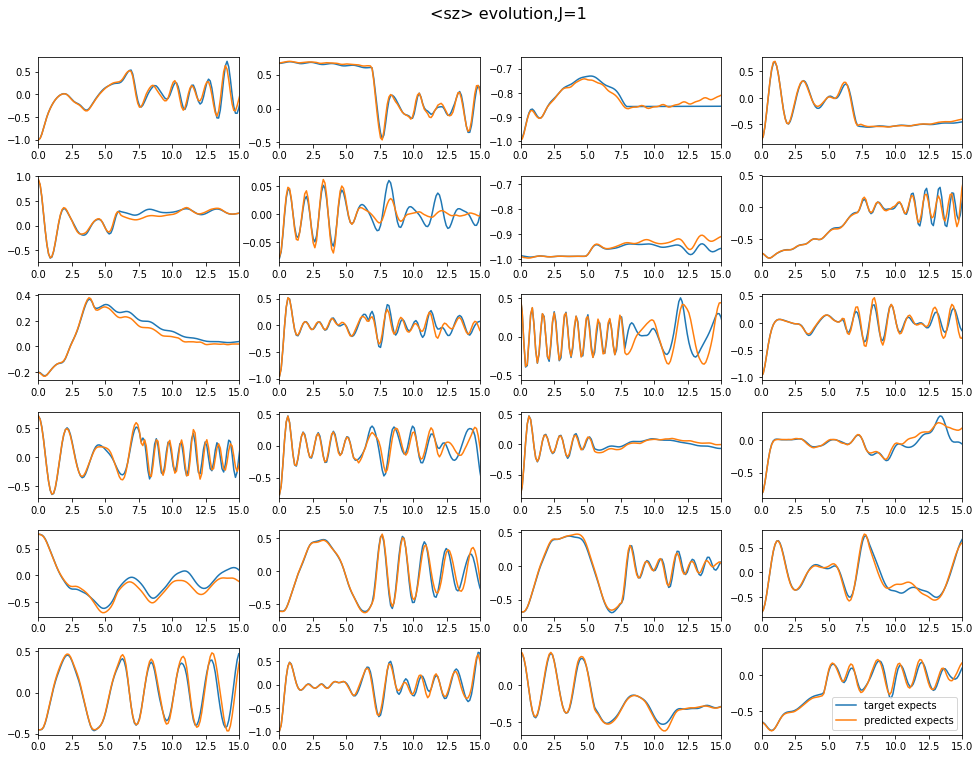

In [15]:
#trained up large b
l=0
kk=17
fig, axes = plt.subplots(6, 4, figsize=(14,10))
fig.tight_layout()
fig.suptitle('<sz> evolution,J=1',size=16, y=1.05)
for j in range(4):
    for k in range(6*j,6*(j+1)):
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_target_step),1,2)[k][l])
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(yy_predict_step),1,2)[k][l])
        axes[k-6*j,j].set_xlim(0,15)
legend=plt.legend(('target expects','predicted expects'))
#legend.draggable()
plt.subplots_adjust(right=0.95)


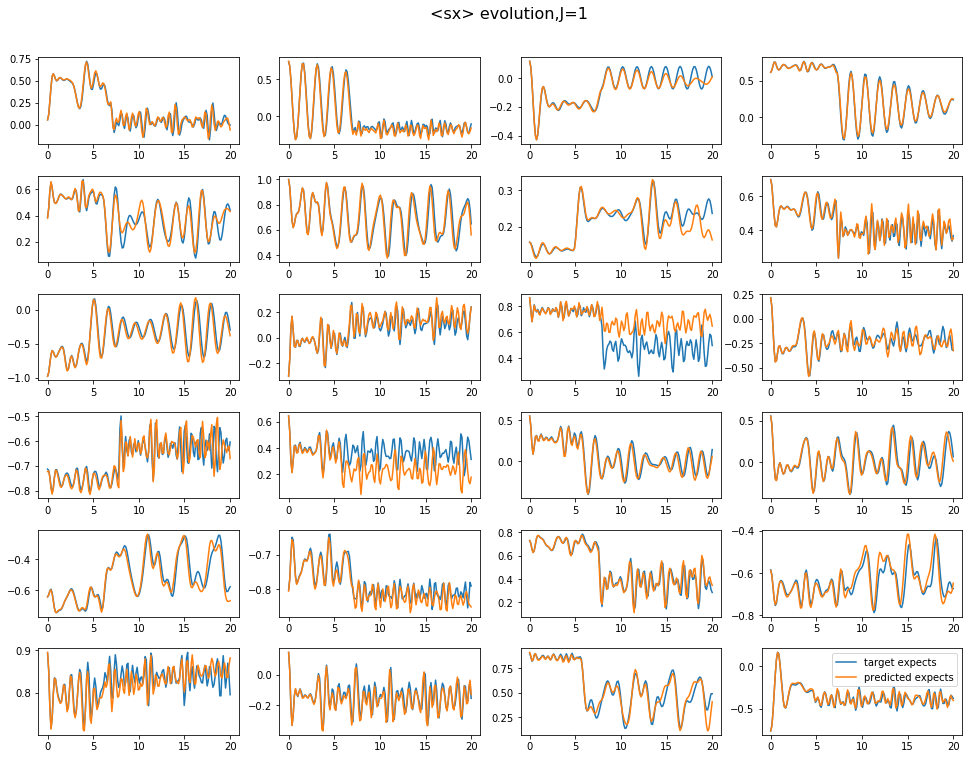

In [16]:
#trained up to 7 late quench
l=2
kk=17
fig, axes = plt.subplots(6, 4, figsize=(14,10))
fig.tight_layout()
fig.suptitle('<sx> evolution,J=1',size=16, y=1.05)
for j in range(4):
    for k in range(6*j,6*(j+1)):
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_target_step),1,2)[k][l])
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(yy_predict_step),1,2)[k][l])
        #axes[k-6*j,j].set_ylim(-0.5,0.5)
legend=plt.legend(('target expects','predicted expects'))
#legend.draggable()
plt.subplots_adjust(right=0.95)


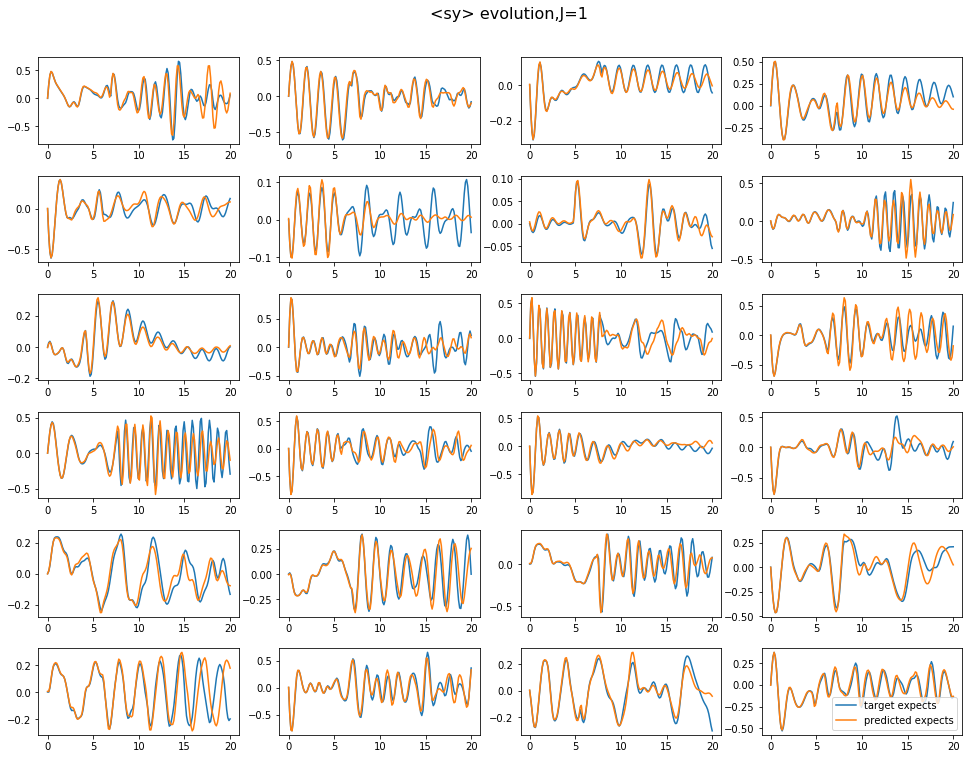

In [18]:
#trained up to 7
l=1
kk=17
fig, axes = plt.subplots(6, 4, figsize=(14,10))
fig.tight_layout()
fig.suptitle('<sy> evolution,J=1',size=16, y=1.05)
for j in range(4):
    for k in range(6*j,6*(j+1)):
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_target_step),1,2)[k][l])
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(yy_predict_step),1,2)[k][l])
        #axes[k-6*j,j].set_ylim(-0.5,0.5)
legend=plt.legend(('target expects','predicted expects'))
#legend.draggable()
plt.subplots_adjust(right=0.95)


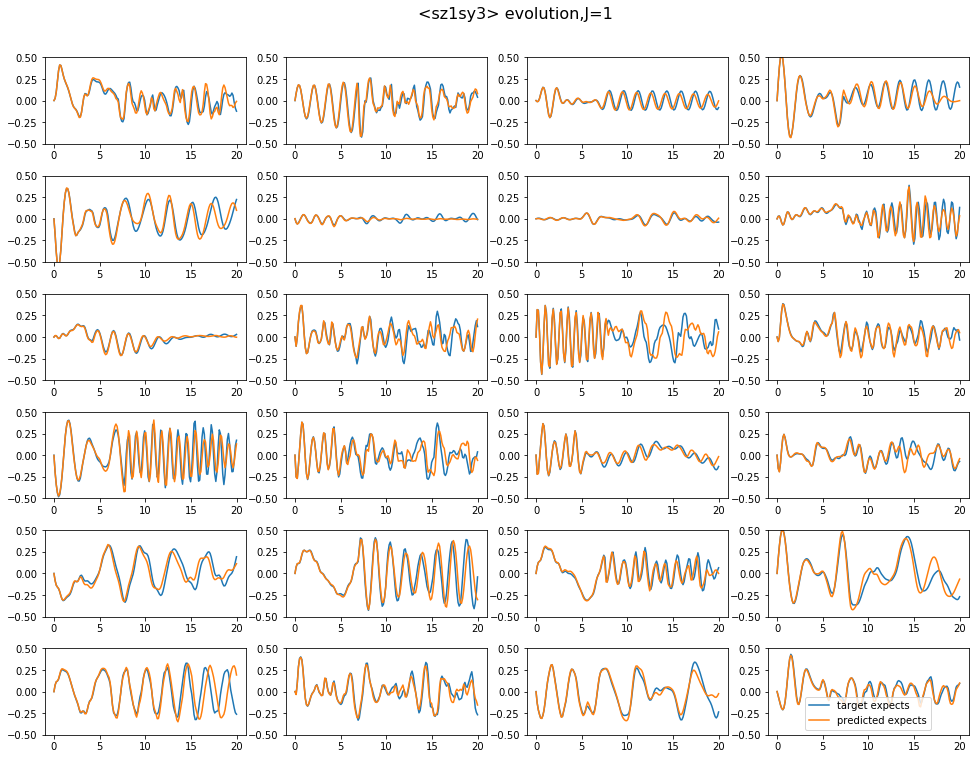

In [19]:

l=3+1*(L-1)

fig, axes = plt.subplots(6, 4, figsize=(14,10))
fig.tight_layout()
fig.suptitle('<sz1sy3> evolution,J=1',size=16, y=1.05)
for j in range(4):
    for k in range(6*j,6*(j+1)):
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_target_step),1,2)[k][l])
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(yy_predict_step),1,2)[k][l])
        axes[k-6*j,j].set_ylim(-0.5,0.5)
legend=plt.legend(('target expects','predicted expects'))
#legend.draggable()
plt.subplots_adjust(right=0.95)

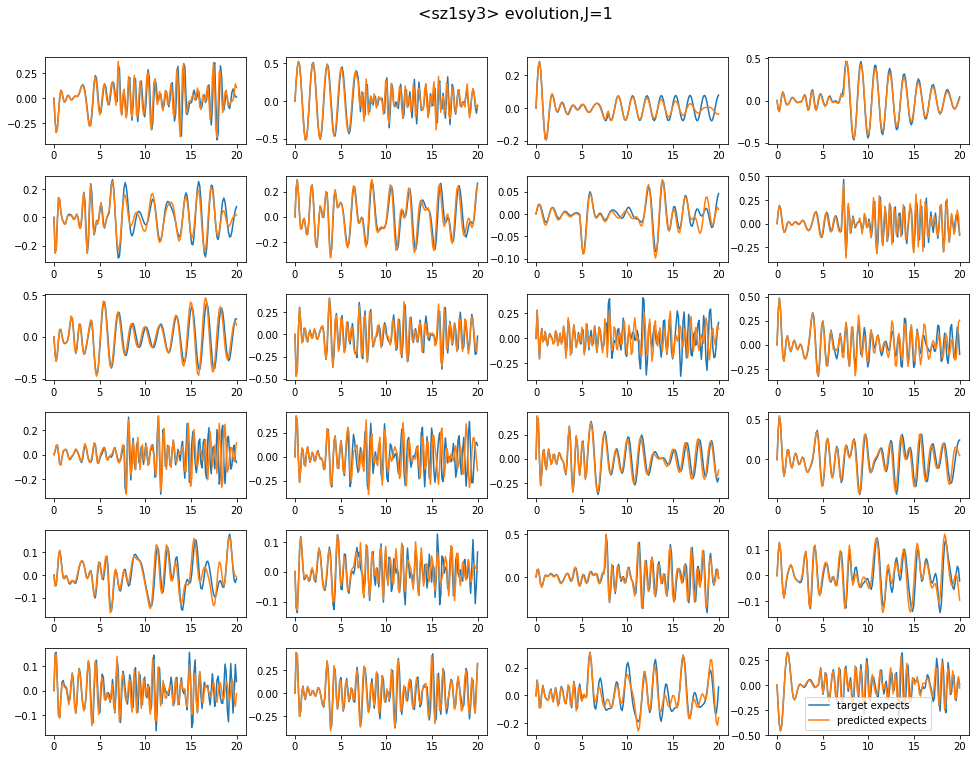

In [21]:
l= 3+5*(L-1)
fig, axes = plt.subplots(6, 4, figsize=(14,10))
fig.tight_layout()
fig.suptitle('<sz1sy3> evolution,J=1',size=16, y=1.05)
for j in range(4):
    for k in range(6*j,6*(j+1)):
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_target_step),1,2)[k][l])
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(yy_predict_step),1,2)[k][l]) 
        #axes[k-6*j,j].set_ylim(-1,1.1)
legend=plt.legend(('target expects','predicted expects'))

#legend.draggable()
plt.subplots_adjust(right=0.95)

# Evaluating the network on periodic field

In [22]:
Data_test_step=pd.read_csv("Data_test_periodic_tau=20,M=7,num_test=1000,seed_test=1451.dat", header=None)
Result_test_step=pd.read_csv("Result_test_periodic_tau=20,M=7,num_test=1000,seed_test=1451.dat", header=None)

1000/1000 [==============================] - 8s 8ms/sample - loss: 0.0018 - mean_squared_error: 0.0018


array([1.49340788e-05, 2.57893862e-05, 3.20795648e-05, 3.04863293e-05,
       3.50461773e-05, 3.67501398e-05, 3.90887021e-05, 4.08469498e-05,
       4.14621865e-05, 4.16450812e-05, 4.19888439e-05, 4.35068168e-05,
       4.43769928e-05, 4.63272226e-05, 4.98118599e-05, 5.46143390e-05,
       6.08601244e-05, 6.88893058e-05, 7.76780767e-05, 8.93217645e-05,
       1.00678704e-04, 1.14125246e-04, 1.25628381e-04, 1.37652231e-04,
       1.52759160e-04, 1.69232903e-04, 1.86413497e-04, 2.04498427e-04,
       2.21428584e-04, 2.40508539e-04, 2.55527716e-04, 2.67832844e-04,
       2.81265254e-04, 3.03967508e-04, 3.22339965e-04, 3.30880614e-04,
       3.45758335e-04, 3.60647504e-04, 3.70266398e-04, 3.78736485e-04,
       3.93184065e-04, 4.16608400e-04, 4.40909060e-04, 4.74711179e-04,
       5.09907554e-04, 5.31019709e-04, 5.43701871e-04, 5.59951564e-04,
       5.78350839e-04, 5.94128342e-04, 6.25116209e-04, 6.57424516e-04,
       6.93926874e-04, 7.31180638e-04, 7.49382132e-04, 7.66563697e-04,
      

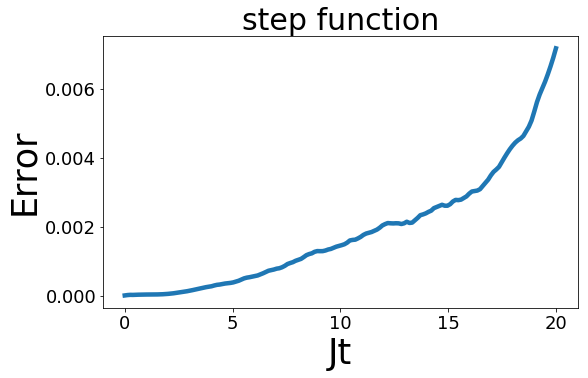

In [23]:

taulist=np.linspace(0,tau_max_extrapolation,extrapolation_steps)
Data_test_step=np.array(Data_test_step)
Result_test_step=np.array(Result_test_step).reshape(len(Result_test_step),len(taulist),9*(L-1)+3)
Result_test_step=Result_test_step[:,:extrapolation_steps,:].reshape(len(Result_test_step),extrapolation_steps*(9*(L-1)+3))
x_test_step=np.zeros((len(Result_test_step),extrapolation_steps,5))
x_test_step[:,:,:1]=Data_test_step.reshape(Data_test_step.shape[0],extrapolation_steps,1)
x_test_step[:,0,1:4]=Result_test_step[:,:3]
x_test_step[:,:,4:5]=(np.repeat(taulist[:,np.newaxis],len(x_test_step),axis=1).T).reshape(len(x_test_step),extrapolation_steps,1)
y_test_step=Result_test_step.reshape(len(Result_test_step),len(taulist),9*(L-1)+3)
error=net.evaluate(x=x_test_step,y=y_test_step)
y_target_step=y_test_step
y_predict_step = net.predict(x_test_step)
yy_predict_step=y_predict_step

num_test=1000
data=(1./(num_test*(9*(L-1)+3)) )*sum((np.swapaxes(np.array(y_target_step),1,2)[:,:,:]-np.swapaxes(np.array(yy_predict_step),1,2)[:,:,:])**2,axis=(0,1))
data2=(1./(num_test*(9*(L-1)+3)) )*sum((np.swapaxes(np.array(y_target_step),1,2)[:,:,:]-np.swapaxes(np.array(yy_predict_step),1,2)[:,:,:])**4,axis=(0,1))

plt.figure(figsize=(8.5,5))

plt.plot(taulist,data,linewidth=4.5)
plt.ylabel('Error' ,size=35)
plt.xlabel(r'Jt' ,size=35)
plt.tick_params(labelsize=18)
plt.title('step function',size=30)
np.sqrt(data)
#step size -3---3 150 000 samples for training t=5


plt.figure(figsize=(8.5,5))

plt.plot(taulist,data,linewidth=4.5)
plt.ylabel('Error' ,size=35)
plt.xlabel(r'Jt' ,size=35)
plt.tick_params(labelsize=18)
plt.title('step function',size=30)
data
#step size -3---3 150 000 samples for training t=5


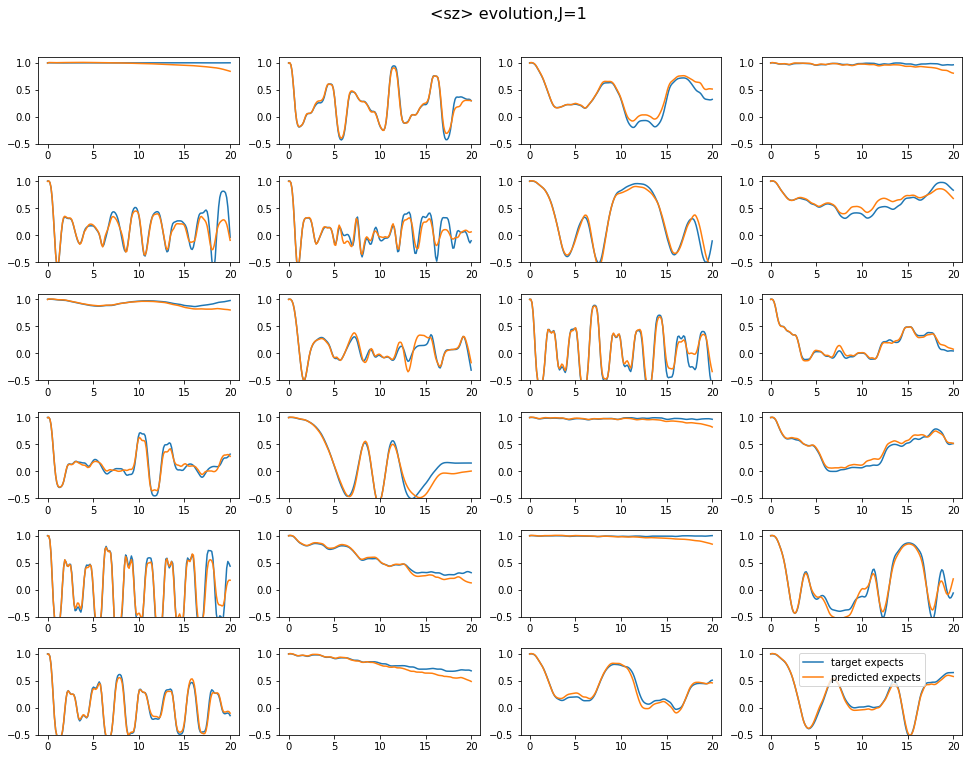

In [27]:
l=0
kk=17
fig, axes = plt.subplots(6, 4, figsize=(14,10))
fig.tight_layout()
fig.suptitle('<sz> evolution,J=1',size=16, y=1.05)
for j in range(4):
    for k in range(6*j,6*(j+1)):
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_target_step),1,2)[k][l])
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(yy_predict_step),1,2)[k][l])
        axes[k-6*j,j].set_ylim(-0.5,1.1)
legend=plt.legend(('target expects','predicted expects'))
#legend.draggable()
plt.subplots_adjust(right=0.95)


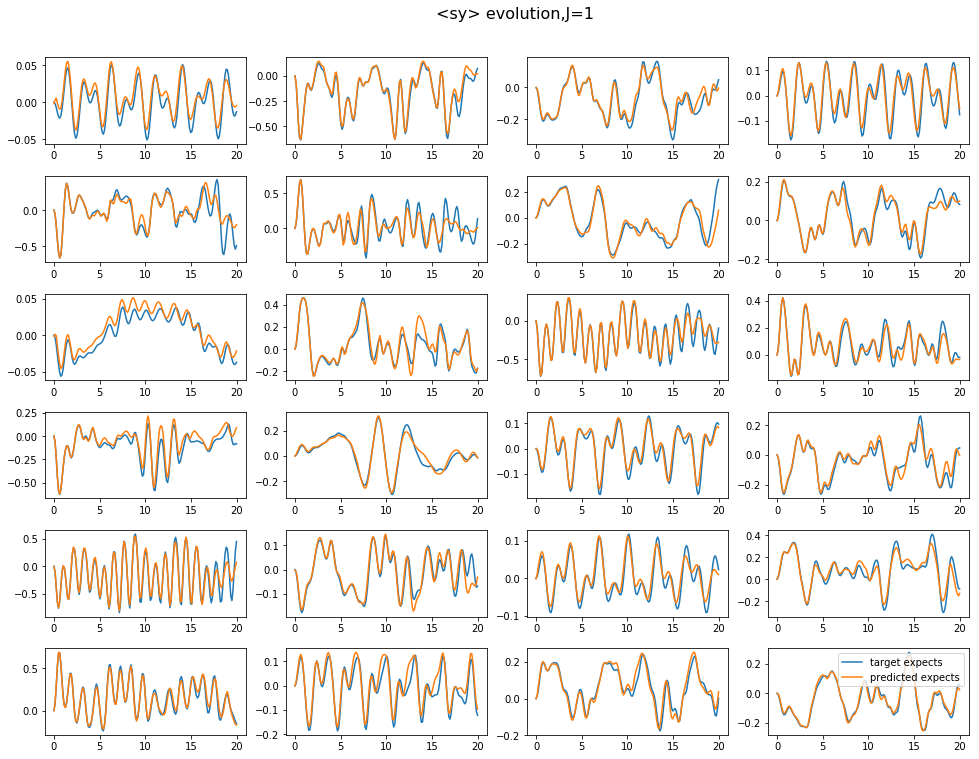

In [28]:
l=1
kk=17
fig, axes = plt.subplots(6, 4, figsize=(14,10))
fig.tight_layout()
fig.suptitle('<sy> evolution,J=1',size=16, y=1.05)
for j in range(4):
    for k in range(6*j,6*(j+1)):
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_target_step),1,2)[k][l])
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(yy_predict_step),1,2)[k][l])
        #axes[k-6*j,j].set_ylim(-0.5,0.5)
legend=plt.legend(('target expects','predicted expects'))
#legend.draggable()
plt.subplots_adjust(right=0.95)


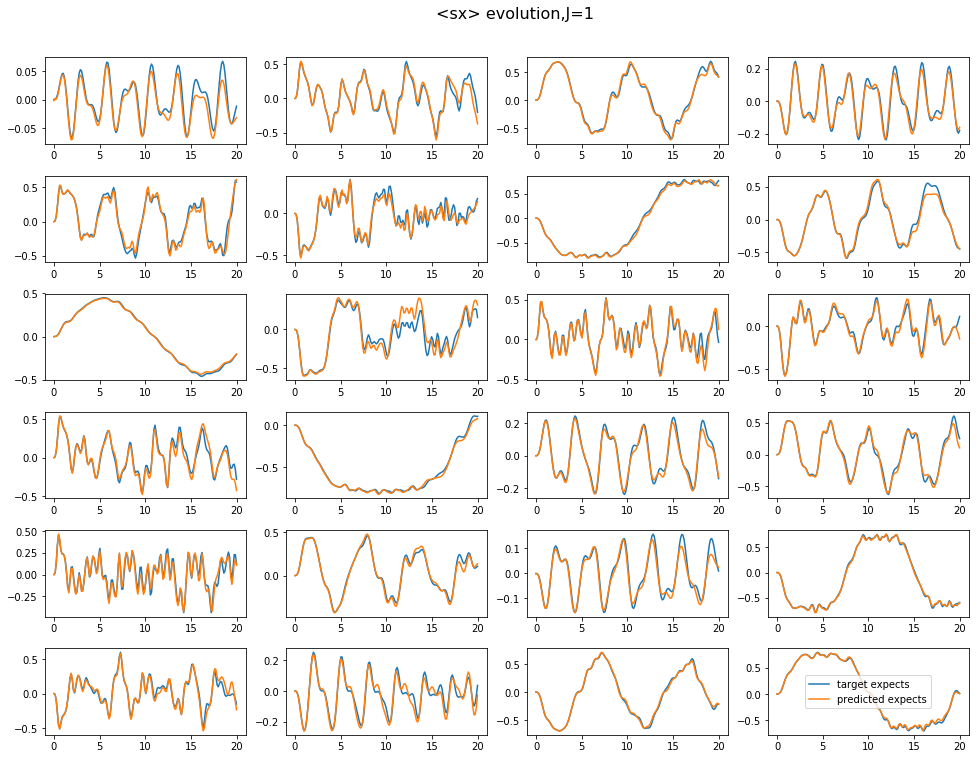

In [29]:
l=2
kk=17
fig, axes = plt.subplots(6, 4, figsize=(14,10))
fig.tight_layout()
fig.suptitle('<sx> evolution,J=1',size=16, y=1.05)
for j in range(4):
    for k in range(6*j,6*(j+1)):
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_target_step),1,2)[k][l])
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(yy_predict_step),1,2)[k][l])
        #axes[k-6*j,j].set_ylim(-0.5,0.5)
legend=plt.legend(('target expects','predicted expects'))
#legend.draggable()
plt.subplots_adjust(right=0.95)


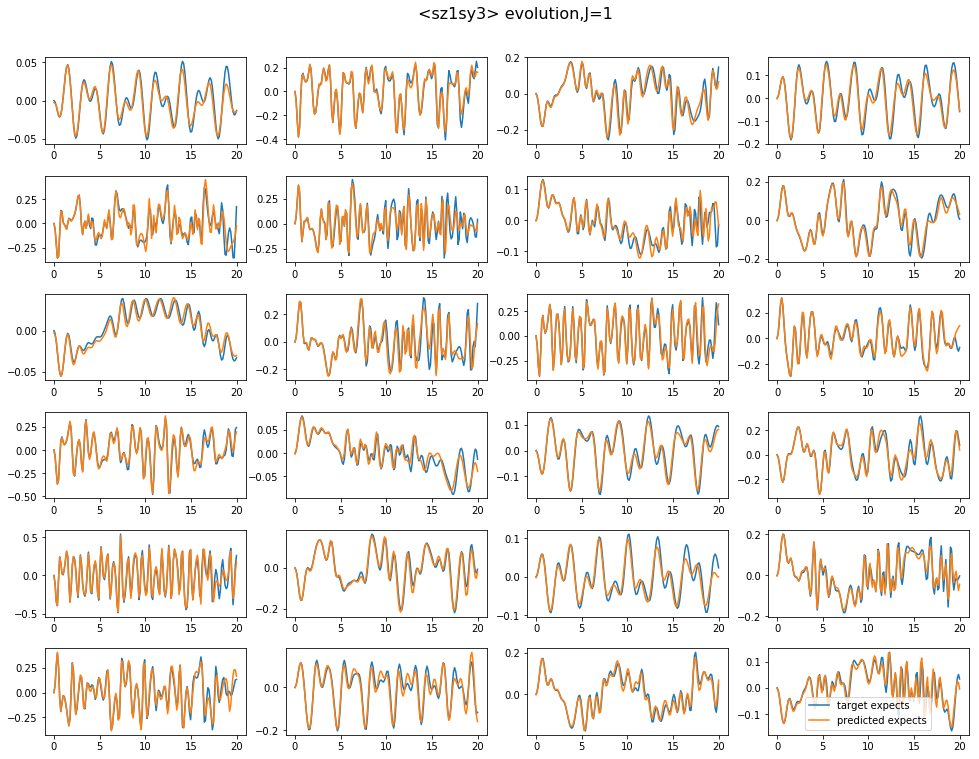

In [30]:
l= 3+5*(L-1)
fig, axes = plt.subplots(6, 4, figsize=(14,10))
fig.tight_layout()
fig.suptitle('<sz1sy3> evolution,J=1',size=16, y=1.05)
for j in range(4):
    for k in range(6*j,6*(j+1)):
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_target_step),1,2)[k][l])
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(yy_predict_step),1,2)[k][l]) 
        #axes[k-6*j,j].set_ylim(-1,1.1)
legend=plt.legend(('target expects','predicted expects'))

#legend.draggable()
plt.subplots_adjust(right=0.95)

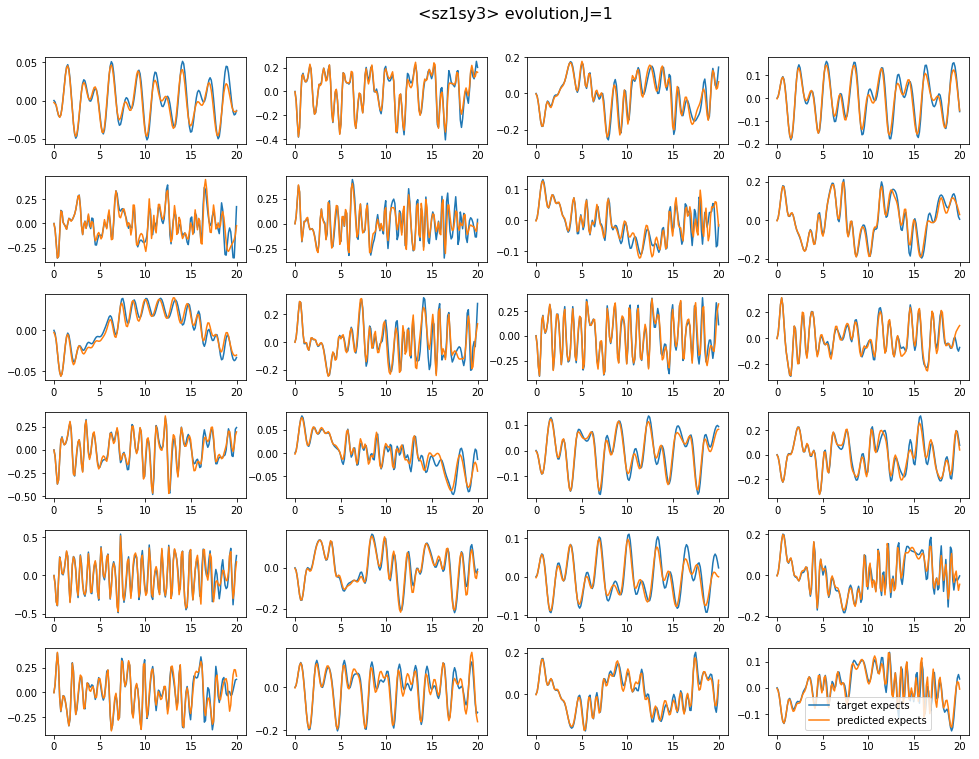

In [32]:
l= 3+7*(L-1)
fig, axes = plt.subplots(6, 4, figsize=(14,10))
fig.tight_layout()
fig.suptitle('<sz1sy3> evolution,J=1',size=16, y=1.05)
for j in range(4):
    for k in range(6*j,6*(j+1)):
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(y_target_step),1,2)[k][l])
        axes[k-6*j,j].plot(taulist,np.swapaxes(np.array(yy_predict_step),1,2)[k][l]) 
        #axes[k-6*j,j].set_ylim(-1,1.1)
legend=plt.legend(('target expects','predicted expects'))

#legend.draggable()
plt.subplots_adjust(right=0.95)